# Определение возраста покупателей

**Описание проекта**    
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - контролировать добросовестность кассиров при продаже алкоголя.  
 
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.
Данные взяты с сайта ```ChaLearn Looking at People.``` Они находятся в папке ```/datasets/faces/.```  
В распоряжении одна папка со всеми изображениями ```(/final_files)``` и CSV-файл ```labels.csv``` с двумя колонками: ```file_name``` и ```real_age```.  
Извлечь данные из папки вам поможет новый метод ```ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...)```.

## Исследовательский анализ данных

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels

file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]

In [6]:
fig = px.histogram(labels['real_age'], nbins=100)
fig.update_layout(title='График распределения возраста')

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


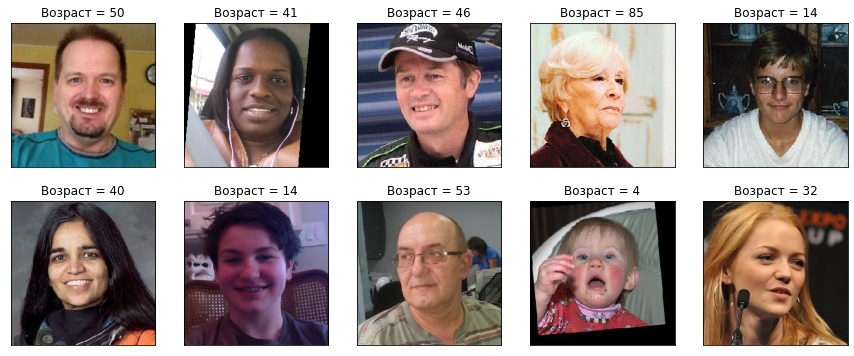

In [8]:
x, y = next(train_gen_flow)
fig = plt.figure(figsize=(15,6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    plt.title(f'Возраст = {y[i]}')
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [103]:
path = '/datasets/faces/final_files/'
list_01 = []
list_02 = []
for i in tqdm(range(len(labels))):
    photo = Image.open(path+labels.file_name[i]) 
    if (photo.size[0] != photo.size[1]) & (photo.size[0]+1 != photo.size[1]) & (photo.size[0] != photo.size[1]+1):
        list_01.append(labels.file_name[i])
        list_02.append(photo.size)

  0%|          | 0/7591 [00:00<?, ?it/s]

In [106]:
df = pd.DataFrame(list_02,list_01, columns = ['h',"w"])
display(df.head(5))
display(df.shape)

h     w
000067.jpg   200   133
000100.jpg   675  1000
000169.jpg  1141  1158
000268.jpg   570   659
000317.jpg  1072  1123

(239, 2)

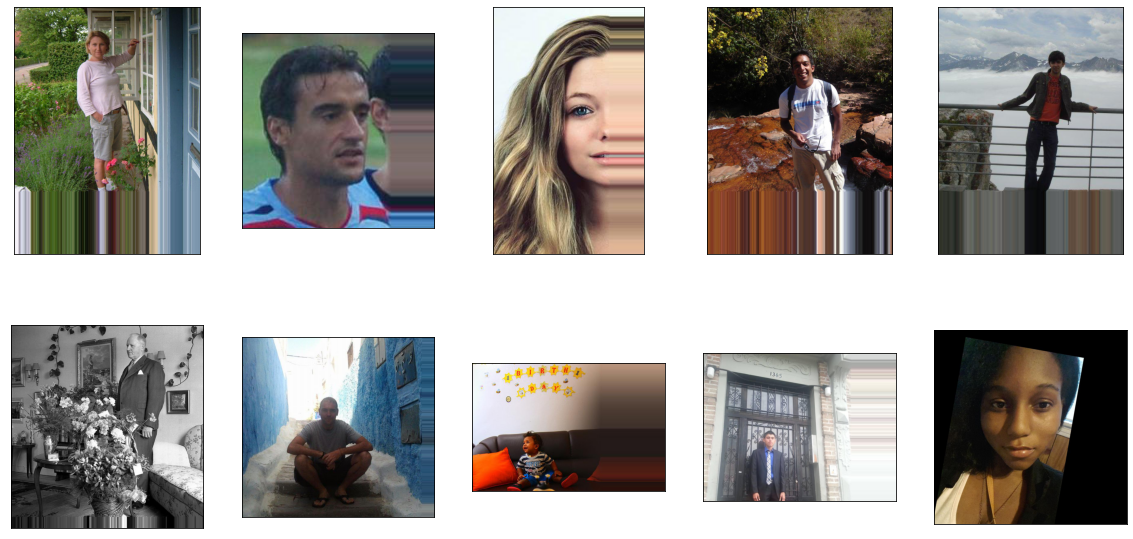

In [112]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    plt.imshow(Image.open(path+list_01[np.random.randint(len(list_01))]))
    plt.xticks([])
    plt.yticks([])
plt.show()


<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Поправил
</div> 

# Выводы
1. Данные имеют размерность (7591, 2)
2. После построения гистограмма удалось установить, что максимальное количество значений приходится на возраст 25 и 30 лет (315 и 317 соотвественно). Имеется выброс слева со значением 149 (возраст - 1 год)
3. Из-за большого количества фотографий детей в возрасте 1 года, возможно, что могут быть ошибки в обучении
4. Были выделины фотографии с разным соотношением сторон, в данных присутствуют как квадратные так и прямоугольные фотографии (основная часть приходится на квадратные), ориентация фотографий - нормальная (поворачивать не нужно)
5. В данных присутствуют следующие типы фотографий:
    - черно-белые
    - смещенные фографии с черным, размыт фонами

## Обучение модели

Обучение модели осуществляется в GPU на мощностях Яндекс.  
Необходимо создать следующие функции:
- load_train(path),
- load_test(path),
- create_model(input_shape),
- train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)

Весь датасет был разбит на тренировочный и тестовый в соотношении 4 : 1, j, обучение происходит батчами   
В качестве модели выбрана предобученная 50-слойная модель ResNet50 с весами resnet50_weights_tf_dim_ordering_tf_kernels_notop  
Последний полносвязный слой был заменён на слой с одним нейроном, так как решаемая задача - регрессия (функция активации - relu)  
Алгоритм оптимизации Adam со скоростью обучения = 0.0001,  
Функция потерь - Mean squared error  
Метрика - Mean absolute error  
Количество эпох обучения - 20

**Код обучения:**

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345) 
     
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)   
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
              metrics=['mean_absolute_error'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

**Результат обучения:**

```

Train for 178 steps, validate for 119 steps
Epoch 1/20
2023-09-27 17:40:16.976687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-27 17:40:17.263581: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 288.3781 - mean_absolute_error: 12.1588 - val_loss: 1147.3148 - val_mean_absolute_error: 29.4388
Epoch 2/20
178/178 - 41s - loss: 69.9207 - mean_absolute_error: 6.2353 - val_loss: 510.0725 - val_mean_absolute_error: 17.2956
Epoch 3/20
178/178 - 40s - loss: 33.6229 - mean_absolute_error: 4.4471 - val_loss: 238.8392 - val_mean_absolute_error: 11.5046
Epoch 4/20
178/178 - 41s - loss: 20.6625 - mean_absolute_error: 3.5357 - val_loss: 117.3930 - val_mean_absolute_error: 8.4332
Epoch 5/20
178/178 - 43s - loss: 15.0734 - mean_absolute_error: 3.0162 - val_loss: 86.3235 - val_mean_absolute_error: 7.2134
Epoch 6/20
178/178 - 43s - loss: 12.1829 - mean_absolute_error: 2.6914 - val_loss: 70.1431 - val_mean_absolute_error: 6.3067
Epoch 7/20
178/178 - 43s - loss: 9.1069 - mean_absolute_error: 2.3382 - val_loss: 75.9075 - val_mean_absolute_error: 6.8461
Epoch 8/20
178/178 - 42s - loss: 8.4344 - mean_absolute_error: 2.1902 - val_loss: 65.6676 - val_mean_absolute_error: 6.1381
Epoch 9/20
178/178 - 42s - loss: 8.3142 - mean_absolute_error: 2.1980 - val_loss: 67.3718 - val_mean_absolute_error: 6.1597
Epoch 10/20
178/178 - 42s - loss: 7.9928 - mean_absolute_error: 2.1500 - val_loss: 67.4275 - val_mean_absolute_error: 6.2043
Epoch 11/20
178/178 - 42s - loss: 6.4587 - mean_absolute_error: 1.9350 - val_loss: 67.4886 - val_mean_absolute_error: 6.2840
Epoch 12/20
178/178 - 43s - loss: 5.5721 - mean_absolute_error: 1.7924 - val_loss: 67.2465 - val_mean_absolute_error: 6.1576
Epoch 13/20
178/178 - 42s - loss: 5.6982 - mean_absolute_error: 1.7874 - val_loss: 64.9701 - val_mean_absolute_error: 6.1102
Epoch 14/20
178/178 - 43s - loss: 5.3310 - mean_absolute_error: 1.7441 - val_loss: 66.5210 - val_mean_absolute_error: 6.0789
Epoch 15/20
178/178 - 43s - loss: 5.6433 - mean_absolute_error: 1.7924 - val_loss: 76.5604 - val_mean_absolute_error: 6.8903
Epoch 16/20
178/178 - 42s - loss: 5.7709 - mean_absolute_error: 1.8262 - val_loss: 66.3080 - val_mean_absolute_error: 6.1125
Epoch 17/20
178/178 - 43s - loss: 5.8777 - mean_absolute_error: 1.8357 - val_loss: 63.5838 - val_mean_absolute_error: 6.0690
Epoch 18/20
178/178 - 42s - loss: 5.7407 - mean_absolute_error: 1.7989 - val_loss: 64.0053 - val_mean_absolute_error: 5.9452
Epoch 19/20
178/178 - 43s - loss: 5.3271 - mean_absolute_error: 1.7612 - val_loss: 72.3342 - val_mean_absolute_error: 6.4609
Epoch 20/20
178/178 - 42s - loss: 5.0004 - mean_absolute_error: 1.6953 - val_loss: 77.4935 - val_mean_absolute_error: 6.4958
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 77.4935 - mean_absolute_error: 6.4958
Test MAE: 6.4958


```

## Анализ обученной модели

Весь датасет был разбит на тренировочный и тестовый в соотношении 4 : 1, обучение происходит батчами   
В качестве модели выбрана предобученная 50-слойная модель ResNet50 с весами ```resnet50_weights_tf_dim_ordering_tf_kernels_notop```  
Последний полносвязный слой был заменён на слой с одним нейроном, так как решаемая задача - регрессия (функция активации - ```ReLU```)  
Алгоритм оптимизации ``Adam`` со скоростью обучения = 0.0001,  
Функция потерь - ```Mean squared error```
Метрика - ```Mean absolute error``` 
Количество эпох обучения - 20
- Значение MAE составило 6.4958 (количество эпох - 20), что соотвествует условию задания (требуемое значение метрики MAE < 8)

- Средняя ошибка на тестовой выборке составила 6 - 7 лет, когда на тренировочной выборке этот показатель составляет около 2 лет. Можно сделать вывод, что модель перееобучилась  
- Для улучшения качества модели можно дополнительно провести увеличение выборки данных (аугментация), а также увеличть количество эпох